In [1]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         57G         16G        946M         51G         65G
Swap:           14G        9.4G        5.5G


In [2]:
import os
import copy
import numpy as np
import pandas as pd
import pydicom
import nibabel as nib

from scipy import ndimage as nd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.utils.data as data

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, r2_score
from IPython.display import clear_output

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
!nvidia-smi

Mon May 20 12:02:37 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:05:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |  14783MiB / 16280MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   30C    P0    32W / 250W |   5023MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

device = 5

Torch version: 1.0.1.post2
Using GPU


In [5]:
# 1.configs & utils
from utils import *

# 2.models
from models_voxresnet import VoxResNet

# 3.loss
from loss import compute_preds, compute_probs

# 4.dataloader
from data_loader_bids import BidsMRI

In [6]:
def train_one_epoch(train_loader, model, opt, criterion):
    train_loss = []
    train_preds = []
    train_targets = []
    
    model.train(True)
    for inputs_batch, targets_batch in tqdm(train_loader):
        inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.long().to(device)
        logits_batch = model(inputs_batch)
        loss = criterion(logits_batch, targets_batch)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss.append(loss.item())
        probs = compute_probs(logits_batch)
        train_preds.extend(list(probs))
        train_targets.extend(list(targets_batch.cpu().data.numpy()))
        
    return train_loss, train_preds, train_targets


# validate func
def validate(val_loader, model, criterion):
    val_loss = []
    val_preds = []
    val_targets = []
    
    model.train(False)
    for inputs_batch, targets_batch in tqdm(val_loader):
        inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.long().to(device)
        logits_batch = model(inputs_batch)
        
        loss = criterion(logits_batch, targets_batch)
        val_loss.append(loss.item())
        probs = compute_probs(logits_batch)
        val_preds.extend(list(probs))
        val_targets.extend(list(targets_batch.cpu().data.numpy()))
        
    return val_loss, val_preds, val_targets


# train func
def train(train_loader, val_loader, model, opt, criterion=nn.CrossEntropyLoss(), n_epochs=100, epsilon=0, metric=roc_auc_score, use_labels=False):
    
    def plot_results(epoch, start_time):
        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(mean_train_loss)
        plt.plot(mean_val_loss)
        plt.subplot(122)
        plt.plot(mean_train_metric)
        plt.plot(mean_val_metric)
        plt.gca().set_ylim([0, 1])
        plt.show()
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(mean_train_loss[-1]))
        print("  validation loss: \t\t\t{:.6f}".format(mean_val_loss[-1]))
        print("  training metric: \t\t\t{:.2f}".format(mean_train_metric[-1]))
        print("  validation metric: \t\t\t{:.2f}".format(mean_val_metric[-1]))
    
    mean_train_loss = []
    mean_train_metric = []
    mean_val_loss = []
    mean_val_metric = []
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        train_loss, train_preds, train_targets = train_one_epoch(train_loader, model, opt, criterion)
        mean_train_loss.append(np.mean(train_loss))
        train_metric = metric(train_targets, train_preds) if not use_labels else metric(train_targets, compute_labels(train_preds))
        mean_train_metric.append(train_metric)
        
        val_loss, val_preds, val_targets = validate(val_loader, model, criterion)
        mean_val_loss.append(np.mean(val_loss))
        val_metric = metric(val_targets, val_preds) if not use_labels else metric(val_targets, compute_labels(val_preds))
        mean_val_metric.append(val_metric)
        
        plot_results(epoch, start_time)
        
        if mean_train_loss[-1] < epsilon:
            break
        
    return mean_train_loss, mean_train_metric, mean_val_loss, mean_val_metric

In [7]:
def cross_val_train(dataset, problem, cv, problem_name, args, load=True, encode_target=False, metric=roc_auc_score, use_labels=False):
    """
    Perform training and validation on each fold and save the result. 
    """
    
    if load:
        train_loss_l, val_loss_l, train_metric_l, val_metric_l = load_results(problem_name, problem)
        test_metric = list(map(lambda x: x[-1], val_metric_l))
        print("test metric mean:", np.mean(test_metric))
        print("test metric std:", np.std(test_metric))
        print(list(map(lambda x: np.round(x, 2), test_metric)))
    else:
        train_loss_l, val_loss_l, train_metric_l, val_metric_l, test_metric = [], [], [], [], []

    dataset.set_target(problem, encode_target=encode_target)
    idx = dataset.target.notnull()
    display(dataset.target[idx].value_counts())
    cv_splits = list(cv.split(X=dataset.target[idx].index, y=dataset.target[idx]))
        
    for i in range(len(test_metric), len(cv_splits)):
        tr_idx, te_idx = cv_splits[i]
        
        train_idx = dataset.target[idx].index[tr_idx]
        train_loader = torch.utils.data.DataLoader(
            data.Subset(dataset, train_idx), batch_size=args["batch_size"], shuffle=True)
        
        val_idx = dataset.target[idx].index[te_idx]
        val_loader = torch.utils.data.DataLoader(
            data.Subset(dataset, val_idx), batch_size=args["batch_size"], shuffle=False)

        model, opt = create_model(args)
        mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric = train(
            train_loader, val_loader, model, opt, criterion=nn.CrossEntropyLoss(), 
            n_epochs=args["num_epochs"], epsilon=args["epsilon"], metric=roc_auc_score, use_labels=use_labels)

        train_loss_l.append(mean_train_loss)
        val_loss_l.append(mean_val_loss)
        train_metric_l.append(mean_train_metric)
        val_metric_l.append(mean_val_metric)

        save_results(problem_name, problem, train_loss_l, val_loss_l, train_metric_l, val_metric_l)

    test_metric = list(map(lambda x: x[-1], val_metric_l))
    print("test metric mean:", np.mean(test_metric))
    print("test metric std:", np.std(test_metric)) 
    
    return test_metric

### VoxResNet on LA5

In [8]:
class ToTensor(object):
    def __call__(self, img):
        return torch.FloatTensor(img)

In [9]:
transform = transforms.Compose([
    ToTensor(),
])

dataset_la5 = BidsMRI(path='../../datasets/LA5study/fmriprep_LA5study_aroma/fmriprep/', 
                  labels_path="../../pominova/LA5study_targets.csv", #'../BIDS_LA5study/participants.tsv'
                  target=None, 
                  encode_target=False,
                  load_online=False, 
                  mri_type="sMRI", 
                  mri_file_suffix='space-MNI152NLin2009cAsym_preproc',
                  brain_mask_suffix=None,
                  transform=transform,
                  coord_min=(20, 40, 20,),
                  img_shape=(152, 152, 152,),
                 )

100%|██████████| 265/265 [01:08<00:00,  3.88it/s]


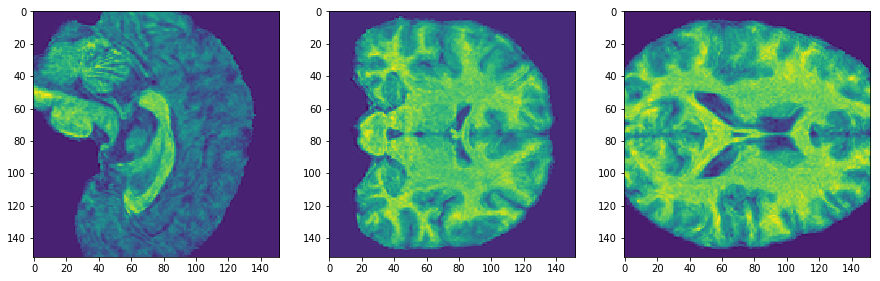

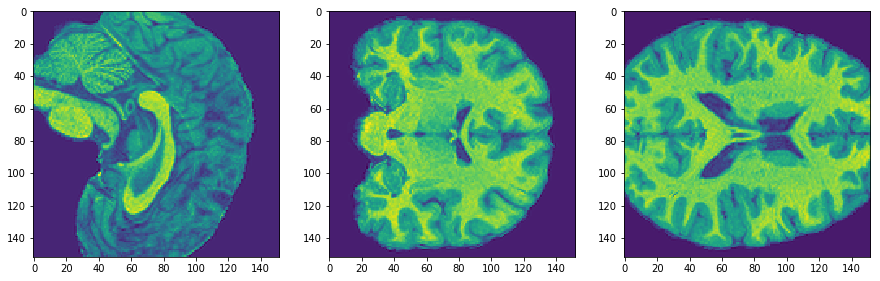

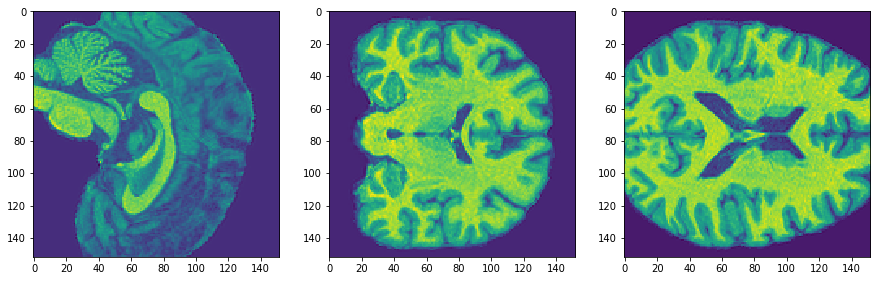

In [11]:
def display_brain(dataset, i):
    n = dataset[i][0]
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(n[n.shape[0] // 2, :, :])
    plt.subplot(132)
    plt.imshow(n[:, n.shape[1] // 2, :])
    plt.subplot(133)
    plt.imshow(n[:, :, n.shape[2] // 2])
    plt.show()

for idx in range(3):
    display_brain(dataset_la5, idx)

In [12]:
def create_model(args):
    model = VoxResNet(args["input_shape"], 
                      args["n_outputs"], 
                      args["n_filters"], 
                      args["stride"], 
                      args["n_blocks"], 
                      args["n_flatten_units"], 
                      args["dropout"], 
                      args["n_fc_units"])
    model = model.to(device)
        
    opt = torch.optim.Adam(model.parameters(), lr=args["learning_rate"])
    return model, opt

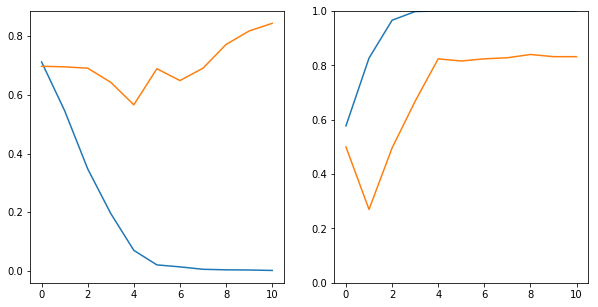

Epoch 11 of 100 took 12.730s
  training loss (in-iteration): 	0.001950
  validation loss: 			0.843372
  training metric: 			1.00
  validation metric: 			0.83
saved.
test metric mean: 0.7504
test metric std: 0.04837189266505916


[0.776, 0.728, 0.696, 0.72, 0.8320000000000001]

In [14]:
problem = "Schz/Control"
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

args = {
    "learning_rate" : 3e-5,
    "batch_size" : 10,
    "num_epochs" : 100,
    "epsilon" : 3e-3,
    "n_outputs" : 2,
    "input_shape" : dataset_la5.output_img_shape,
    "n_filters" : 32,
    "stride" : 2,
    "n_blocks" : 4,
    "n_flatten_units" : 16000,
    "dropout" : 0,
    "n_fc_units" : 128,
}
problem_name = "smri_VoxResNet-fil({})-s({})-block({})-D({})-{}_LA5".format(args["n_filters"], args["stride"], args["n_blocks"], args["dropout"], args["n_fc_units"])
load = True
cross_val_train(dataset_la5, problem, cv, problem_name, args, load)

### VoxResNet on Siblings

In [17]:
transform = transforms.Compose([
    ToTensor(),
])

dataset_siblings = BidsMRI(path='../../fmriprep_ds00115/fmriprep/', 
                  labels_path="../../pominova/ds00115_targets.csv",
                  target=None, 
                  encode_target=False,
                  load_online=False, 
                  mri_type="sMRI", 
                  mri_file_suffix='space-MNI152NLin2009cAsym_preproc',
                  brain_mask_suffix=None,
                  transform=transform,
                  coord_min=(20, 40, 20,),
                  img_shape=(152, 152, 152,),
                 )

100%|██████████| 99/99 [00:23<00:00,  4.15it/s]


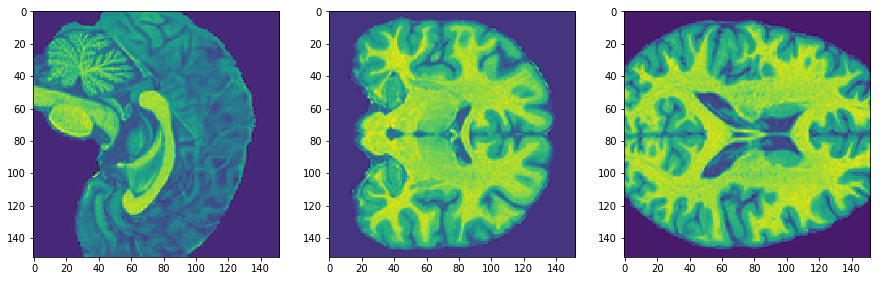

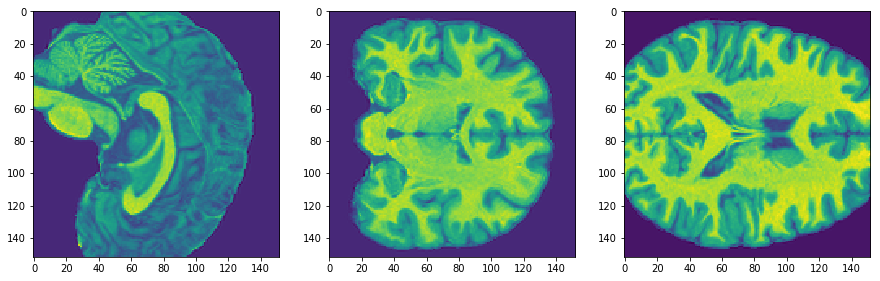

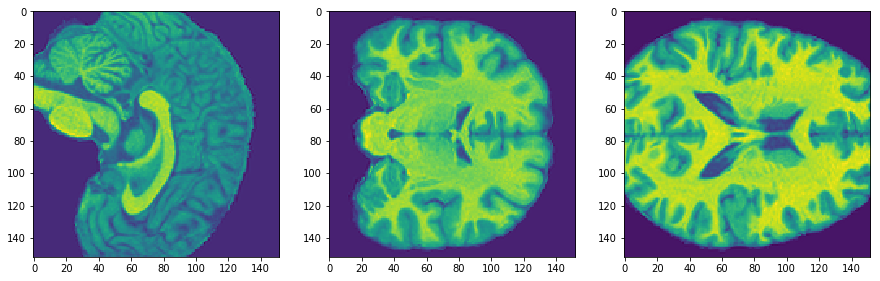

In [18]:
for idx in range(3):
    display_brain(dataset_siblings, idx)

In [26]:
def create_model(args):
    model = VoxResNet(args["input_shape"], 
                      args["n_outputs"], 
                      args["n_filters"], 
                      args["stride"], 
                      args["n_blocks"], 
                      args["n_flatten_units"], 
                      args["dropout"], 
                      args["n_fc_units"])
    model = model.to(device)
        
    opt = torch.optim.Adam(model.parameters(), lr=args["learning_rate"])
    return model, opt

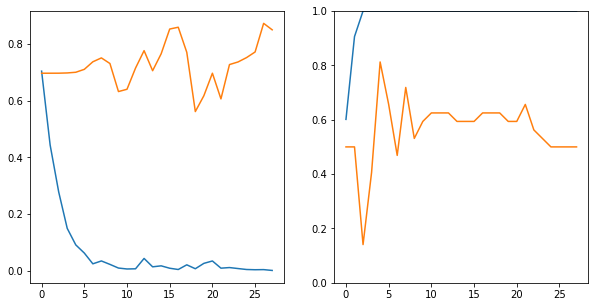

Epoch 28 of 100 took 5.477s
  training loss (in-iteration): 	0.002013
  validation loss: 			0.848805
  training metric: 			1.00
  validation metric: 			0.50
saved.
test metric mean: 0.6347222222222222
test metric std: 0.1574634976317361


[0.711111111111111, 0.39999999999999997, 0.75, 0.8125, 0.5]

In [27]:
problem = "Schz/Control"
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

args = {
    "learning_rate" : 3e-5,
    "batch_size" : 10,
    "num_epochs" : 100,
    "epsilon" : 3e-3,
    "n_outputs" : 2,
    "input_shape" : dataset_siblings.output_img_shape,
    "n_filters" : 32,
    "stride" : 2,
    "n_blocks" : 4,
    "n_flatten_units" : 16000,
    "dropout" : 0,
    "n_fc_units" : 128,
}
problem_name = "smri_VoxResNet-fil({})-s({})-block({})-D({})-{}_Siblings".format(args["n_filters"], args["stride"], args["n_blocks"], args["dropout"], args["n_fc_units"])
load = False
cross_val_train(dataset_siblings, problem, cv, problem_name, args, load)

### LA5 pretrained VoxResNet on Siblings

In [21]:
# training on LA5
problem = "Schz/Control"

args = {
    "learning_rate" : 3e-5,
    "batch_size" : 10,
    "num_epochs" : 100,
    "epsilon" : 3e-3,
    "n_outputs" : 2,
    "input_shape" : dataset_la5.output_img_shape,
    "n_filters" : 32,
    "stride" : 2,
    "n_blocks" : 4,
    "n_flatten_units" : 16000,
    "dropout" : 0,
    "n_fc_units" : 128,
}

dataset_la5.set_target(problem, encode_target=False)
train_idx = dataset_la5.target[dataset_la5.target.notnull()].index
train_loader = torch.utils.data.DataLoader(
    data.Subset(dataset_la5, train_idx), batch_size=args["batch_size"], shuffle=True)

model, opt = create_model(args)
mean_train_loss = []
for epoch in range(args["num_epochs"]):
    start_time = time.time()
    train_loss, train_preds, train_targets = train_one_epoch(train_loader, model, opt, criterion=nn.CrossEntropyLoss())
    mean_train_loss.append(np.mean(train_loss))
    if mean_train_loss[-1] < args["epsilon"]:
        break
print("pretrained.")

# save pretrained model
problem_name = "smri_VoxResNet-fil({})-s({})-block({})-D({})-{}_LA5_pretrained".format(args["n_filters"], args["stride"], args["n_blocks"], args["dropout"], args["n_fc_units"])
state = {
    "model" : model.state_dict(),
}
filename = "models/" + problem_name + "_" + problem.replace("/", "_") + ".pth.tar"
save_checkpoint(state, filename)

  0%|          | 0/18 [00:00<?, ?it/s]

16000


100%|██████████| 18/18 [00:14<00:00,  1.27it/s]

pretrained.


In [22]:
# validation on Siblings
problem = "Schz/Control"

args = {
    "learning_rate" : 3e-5,
    "batch_size" : 10,
    "num_epochs" : 100,
    "epsilon" : 3e-3,
    "n_outputs" : 2,
    "input_shape" : dataset_siblings.output_img_shape,
    "n_filters" : 32,
    "stride" : 2,
    "n_blocks" : 4,
    "n_flatten_units" : 16000,
    "dropout" : 0,
    "n_fc_units" : 128,
}

dataset_siblings.set_target(problem, encode_target=False)
val_idx = dataset_siblings.target[dataset_siblings.target.notnull()].index
val_loader = torch.utils.data.DataLoader(
    data.Subset(dataset_siblings, val_idx), batch_size=args["batch_size"], shuffle=False)

val_loss, val_preds, val_targets = validate(val_loader, model, criterion=nn.CrossEntropyLoss())
val_metric = roc_auc_score(val_targets, val_preds)
print("test metric:", val_metric)

100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

test metric: 0.6744432661717922


### LA5 pretrained VoxResNet on Siblings (finetuning)

In [23]:
problem_name = "smri_VoxResNet-fil({})-s({})-block({})-D({})-{}_LA5_pretrained".format(args["n_filters"], args["stride"], args["n_blocks"], args["dropout"], args["n_fc_units"])
filename = "models/" + problem_name + "_" + problem.replace("/", "_") + ".pth.tar"

def create_model(args):
    model = VoxResNet(args["input_shape"], 
                      args["n_outputs"], 
                      args["n_filters"], 
                      args["stride"], 
                      args["n_blocks"], 
                      args["n_flatten_units"], 
                      args["dropout"], 
                      args["n_fc_units"])
    state = load_checkpoint(filename)
    model.load_state_dict(state["model"])
    model = model.to(device)
        
    opt = torch.optim.Adam(model.parameters(), lr=args["learning_rate"])
    return model, opt

In [25]:
problem = "Schz/Control"
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

args = {
    "learning_rate" : 1e-5,
    "batch_size" : 10,
    "num_epochs" : 100,
    "epsilon" : 3e-3,
    "n_outputs" : 2,
    "input_shape" : dataset_siblings.output_img_shape,
    "n_filters" : 32,
    "stride" : 2,
    "n_blocks" : 4,
    "n_flatten_units" : 16000,
    "dropout" : 0,
    "n_fc_units" : 128,
}
problem_name = "smri_LA5_pretrained_VoxResNet-fil({})-s({})-block({})-D({})-{}_Siblings".format(args["n_filters"], args["stride"], args["n_blocks"], args["dropout"], args["n_fc_units"])
load = True
cross_val_train(dataset_siblings, problem, cv, problem_name, args, load)

test metric mean: 0.6509722222222222
test metric std: 0.22066100893496687
[0.71, 0.32, 0.75, 0.97, 0.5]


0.0    41
1.0    23
Name: Schz/Control, dtype: int64

test metric mean: 0.6509722222222222
test metric std: 0.22066100893496687


[0.711111111111111, 0.325, 0.75, 0.96875, 0.5]

In [ ]:
# nu takooe